# Classification_Patient_readmission

#### 2024.11.1
#### Chulwon Chae

### Purpose of Data Analysis
Background : Diabetes affects over 9% of the global adult population and is steadily increasing. Diabetic patients require ongoing monitoring and treatment, with more severe cases needing extra care. 

Goal : Our primary goal is to develop a model to predict which patients may require readmission within 30 days. 

- Imagine that hospitals could take more preventive actions, such as monitoring critical patients closely, scheduling early follow-ups, or setting up nurse alerts. 

- This could potentially save many lives. By building a model to predict readmissions for diabetic patients, we aim to analyze error distribution to improve the model’s performance.

In [22]:
from sklearn.datasets import fetch_openml
X_orig, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

In [23]:
X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  object  
 1   gender                    101766 non-null  object  
 2   age                       101766 non-null  object  
 3   discharge_disposition_id  101766 non-null  object  
 4   admission_source_id       101766 non-null  object  
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         101766 non-null  object  
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  primary_diagnosis         101766 non-null  object  
 11  number_diagnoses          101766 non-null  int64   
 12  max_glu_serum             101766 non-null  object  
 13  A1Cresult                 101

In [24]:
y 

0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: readmit_30_days, Length: 101766, dtype: int64

## Problem Definition
- Increasing number of readmissions among discharged patients.

## Expected Outcomes
- Predicting readmissions to enable proactive measures and monitoring for critical patients.
- Improving survival rates of high-risk patients.

## Solution Approach
- Use binary classification to identify patients likely to be readmitted within 30 days.
- Data preparation through encoding.
- Building a base model.
- Analyzing the impact of class weights on error.
- Hyperparameter tuning.
- Categorizing errors into different thematic groups.
- Analyzing feature importance.

## Additional: Discuss methods to reduce errors.
## Performance Measurement
- Gradual performance improvement through error analysis.

## Key Highlights
- Using OneHotEncoder for feature generation.
- Building a base model with LightGBMClassifier and tuning with Optuna.
- Conducting general and cohort-specific error analysis.

In [25]:
#!pip install raiwidgets lightgbm optuna shap --quiet

In [26]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)  


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb 
import optuna # hyperparameter tunning 

from responsibleai import RAIInsights 
from raiwidgets import ResponsibleAIDashboard

import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

### 1-1. Drop columns that is highly related with Target

In [27]:
X_orig['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [28]:
X_orig['readmit_binary'].value_counts()

0    54864
1    46902
Name: readmit_binary, dtype: int64

_Actual Target_

In [29]:
y.value_counts()

0    90409
1    11357
Name: readmit_30_days, dtype: int64

### 1-2. Encoding

In [30]:
from sklearn.preprocessing import OneHotEncoder

# Function for data transformation and encoding
def transform_data(X_):
    # Remove alternative target columns
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    # Binary encode boolean columns (True ->1 , False -> 0)
    bool_cols_l = X.select_dtypes(include=["category"]).columns.tolist()
    X[bool_cols_l] = X[bool_cols_l].astype(str).replace({"True": 1, "False": 0})
    print(bool_cols_l)

    # One-hot encode categorical columns
    cat_cols_l = X.select_dtypes(include=["object"]).columns.tolist()
    print(cat_cols_l)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_np = ohe.fit_transform(X[cat_cols_l].astype("category"))
    X[ohe.get_feature_names_out(cat_cols_l)] = ohe_np.astype(int)

    # Drop original categorical columns
    X.drop(cat_cols_l, axis=1, inplace=True)

    return X


In [31]:
X = transform_data(X_orig)

['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']


In [32]:
print(f"Number of Features: {len(X_orig.columns)}")
print(X_orig.columns)

Number of Features: 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')


In [33]:
print(f"Number of Features(After processing): {len(X.columns)}")
print(X.columns)

Number of Features(After processing): 54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_'30 years or younger'',
       'age_'30-60 years'', 'age_'Over 60 years'',
       'discharge_disposition_id_'Discharged to Home'',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_'Genitourinary Issues'',
       'prima

### 1-3. Data split

In [34]:
rand = 1234
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

In [39]:
classes_l = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=rand)
X_orig_test = X_orig.loc[X_test.index]

In [40]:
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_'30 years or younger',age_'30-60 years',age_'Over 60 years',discharge_disposition_id_'Discharged to Home',discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_'Genitourinary Issues',primary_diagnosis_'Musculoskeletal Issues',primary_diagnosis_'Respiratory Issues',primary_diagnosis_Diabetes,primary_diagnosis_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
47866,3,37,1,13,3,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
24673,3,57,0,10,6,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
61033,4,71,0,11,9,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
74444,1,29,0,6,5,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
56971,10,49,1,18,4,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89460,9,72,4,22,9,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
60620,3,1,3,9,5,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
34086,5,14,4,23,9,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
58067,3,45,6,13,6,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0


In [41]:
X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_'30 years or younger',age_'30-60 years',age_'Over 60 years',discharge_disposition_id_'Discharged to Home',discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_'Genitourinary Issues',primary_diagnosis_'Musculoskeletal Issues',primary_diagnosis_'Respiratory Issues',primary_diagnosis_Diabetes,primary_diagnosis_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
28004,1,16,3,19,7,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1
81934,6,78,2,17,9,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1
12445,3,19,0,10,8,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0
42240,2,30,0,17,9,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
35502,1,49,0,9,5,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72313,5,36,0,21,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
69668,3,28,3,22,9,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
5049,4,66,0,21,9,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
43029,4,25,2,13,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1


### 1-4. Modeling Evaluation 

### Evaluation 

In [57]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    y_train_pred = fitted_model.predict(X_train).squeeze()  # 평평하게 squeeze (1차원으로 쭉~)
    if len(np.unique(y_train_pred)) > 2:  # if multiclass, 예를들어 0.4, 0.5, 0.6,....이렇게 예측하면
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:    # 고유 값이 2 이하인경우 (train), 
        y_test_prob = fitted_model.predict_proba(X_test)[:,1] # 양성클래스 1 에대한 확율값 가져와서
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    roc_auc_te = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel() # 눞히면 저 4개 순서로 
    acc_tr = metrics.accuracy_score(y_train, y_train_pred)
    acc_te = metrics.accuracy_score(y_test, y_test_pred)
    pre_te = metrics.precision_score(y_test, y_test_pred)
    rec_te = metrics.recall_score(y_test, y_test_pred)
    f1_te = metrics.f1_score(y_test, y_test_pred)
    mcc_te = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f"Accuracy_train:  {acc_tr:.4f}\t\tAccuracy_test:   {acc_te:.4f}")
        print(f"Precision_test:  {pre_te:.4f}\t\tRecall_test:     {rec_te:.4f}")
        print(f"ROC-AUC_test:    {roc_auc_te:.4f}\t\tF1_test:     {f1_te:.4f}\t\tMCC_test: {mcc_te:.4f}")
        plt.figure(figsize=(6, 5))
        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred
    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train':acc_tr , 'accuracy_test':acc_te, 'precision':pre_te, 'recall':rec_te,\
                      'roc_auc':roc_auc_te,  'f1':f1_te, 'mcc': mcc_te, 'tn%':tn/t, 'fp%':fp/t, 'fn%':fn/t, 'tp%':tp/t }
        return metrics_dict

### 1-5. Baseline model

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
Accuracy_train:  0.8890		Accuracy_test:   0.8876
Precision_test:  0.7500		Recall_test:     0.0009
ROC-AUC_test:    0.6435		F1_test:     0.0017		MCC_test: 0.0231


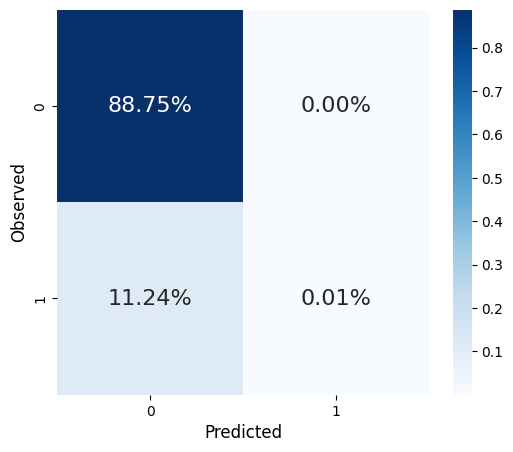

In [58]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

# scale_pos_weight

Based on the numbers alone, the accuracy appears to be very high; however, both precision and recall are very low, indicating that the overall performance is poor.

#### 1-5-1. Class Weights

The model is generally conservative when predicting the Positive class, which means it does not take on too much risk. 
A solution is to use a hyperparameter that forces the model to give more weight to the Positive class. 
There are several ways to assign class weights, and one approach is to use scale_pos_weight.

A commonly used value for this parameter can be calculated with the following formula.

$\large{\frac{\text{number of negative samples}}{\text{number of positive samples}}}$

In [60]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f"default scale pos weight: {def_scale_pos_weight:.2f}")

default scale pos weight: 7.96


This value does indeed improve the model's performance, but there is still a significant level of false positives.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
Accuracy_train:  0.6363		Accuracy_test:   0.6100
Precision_test:  0.1629		Recall_test:     0.5959
ROC-AUC_test:    0.6417		F1_test:     0.2559		MCC_test: 0.1334


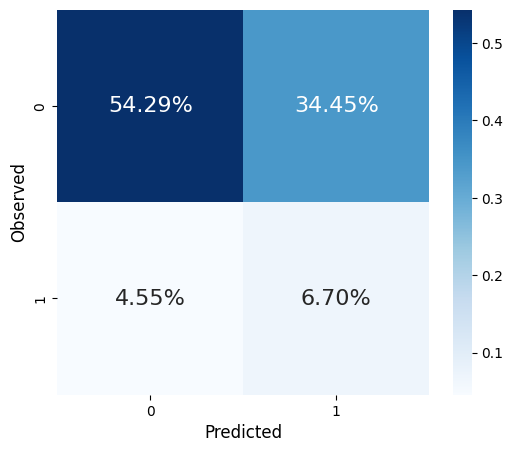

In [61]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)
_ =  evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

# 1로 예측이 늘었는데, 잘못된

And if doubled, the false positives also double.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
Accuracy_train:  0.3425		Accuracy_test:   0.3221
Precision_test:  0.1291		Recall_test:     0.8748
ROC-AUC_test:    0.6372		F1_test:     0.2251		MCC_test: 0.0942


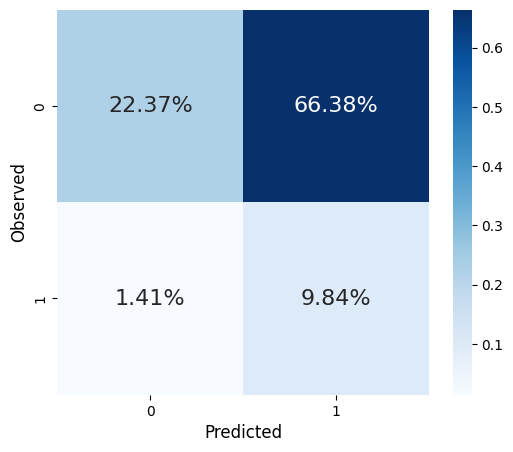

In [62]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)



And if halved, the model becomes more conservative.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
Accuracy_train:  0.8769		Accuracy_test:   0.8593
Precision_test:  0.2190		Recall_test:     0.0978
ROC-AUC_test:    0.6448		F1_test:     0.1352		MCC_test: 0.0775


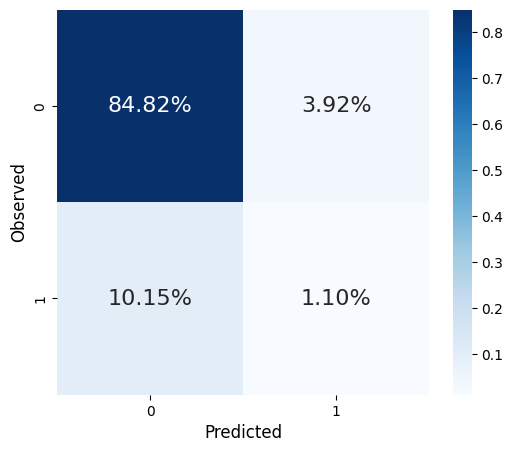

In [63]:
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)

_ = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)
# 배울점은 scale_pos_weight 조정하면 이렇게 된다~

#### 1-5-2. Hyperparameter tuning

A conservative approach is challenging to apply in practice due to the following characteristics:

- Focuses on maximizing only True Positives (correct detections)
- Minimizes False Positives (missed detections)
- Has significantly more false negatives than false positives

Looking at the current model results, there is an issue where almost everything is predicted to belong to the Positive class.

To address this, certain constraints need to be defined. For example, there should be a sufficient number of true negatives to ensure that all data without readmission is properly accounted for.

In [64]:
min_tn = X_orig[X_orig['readmitted']=='NO'].shape[0] / X_orig.shape[0]
print(f"Patients % that never readmitted (Minimum % of True Negatives): {min_tn:.2%}")

Patients % that never readmitted (Minimum % of True Negatives): 53.91%


Additionally, we need to adjust the ratio to ensure that patients readmitted after 30 days are also included as False Positives.

In [65]:
max_fp = X_orig[X_orig['readmitted']=='>30'].shape[0] / X_orig.shape[0]
print(f"Patients % that were readmitted over 30 days later (Maximum % of False Positives): {max_fp:.2%}")

Patients % that were readmitted over 30 days later (Maximum % of False Positives): 34.93%


**Define optimization fuction**

In addition to using class weighting with 'scale_pos_weight', this function searches for optimal hyperparameters for max_depth (to limit tree depth) and L1/L2 regularization with reg_lambda and reg_alpha. This helps the model generalize effectively. The objective function outputs recall except in cases where the two constraints are not met; in those cases, it returns 0.

In [66]:
def optimize_lgb(trial): 
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 11),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), #L2
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True) # L1
    }
    if params['max_depth'] == 11: #오버피팅일수 있지만 우선 그냥 해봐라
        params['max_depth'] = -1

    clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params) # **카워드까지 같이?
    clf.fit(X_train, y_train)

    metrics_dict = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test, plot=False) # 여러번뜨니까

    if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp): #제약조건 해당하지 않하면 0, 이걸 잘줘야함. 
        return 0 

    return metrics_dict['recall']

**Run optimization trials**

In [67]:
%%time
opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(optimize_lgb, n_trials=100)

[I 2024-11-02 20:28:17,812] A new study created in memory with name: no-name-88046542-b97c-4880-aecd-a8feab087f0d


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:18,537] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 13.333216830825325, 'reg_lambda': 7.684057523088796e-05, 'reg_alpha': 0.06707499150555431}. Best is trial 0 with value: 0.0.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:18,970] Trial 1 finished with value: 0.1930131004366812 and parameters: {'max_depth': 4, 'scale_pos_weight': 4.696801342360674, 'reg_lambda': 4.5375386924621126e-05, 'reg_alpha': 1.2661628337856736e-05}. Best is trial 1 with value: 0.1930131004366812.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:19,619] Trial 2 finished with value: 0.5598253275109171 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.30898403493728, 'reg_lambda': 7.009686354022247e-06, 'reg_alpha': 2.4717540021975143e-05}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:20,209] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 13.109238020271807, 'reg_lambda': 1.2652265943051903e-05, 'reg_alpha': 0.009719768898700312}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[I 2024-11-02 20:28:20,659] Trial 4 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 8.475600630802447, 'reg_lambda': 0.00026951488499358026, 'reg_alpha': 7.400016517991369e-08}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:21,418] Trial 5 finished with value: 0.17933042212518194 and parameters: {'max_depth': 11, 'scale_pos_weight': 4.545351978673949, 'reg_lambda': 0.8458844194589055, 'reg_alpha': 1.976307057523686e-05}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:21,854] Trial 6 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 15.478005762637029, 'reg_lambda': 0.0011980647470515424, 'reg_alpha': 0.0027406310125855}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:22,124] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 8.133221798325263, 'reg_lambda': 3.3365958552601203e-06, 'reg_alpha': 1.0090123743868704e-07}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:22,704] Trial 8 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 10.127832426177676, 'reg_lambda': 1.3343008599488364e-05, 'reg_alpha': 1.5730718387564563e-06}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:23,369] Trial 9 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.7408116137534, 'reg_lambda': 5.676708522314674e-06, 'reg_alpha': 7.164588881420783e-05}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:28:24,055] Trial 10 finished with value: 0.4631732168850073 and parameters: {'max_depth': 9, 'scale_pos_weight': 6.54068931003109, 'reg_lambda': 1.0353115904317137e-08, 'reg_alpha': 0.4099404102667173}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:24,798] Trial 11 finished with value: 0.4724890829694323 and parameters: {'max_depth': 9, 'scale_pos_weight': 6.50932234980481, 'reg_lambda': 1.2253581380620443e-08, 'reg_alpha': 9.094750726039553}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:25,483] Trial 12 finished with value: 0.510334788937409 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.800789123545003, 'reg_lambda': 1.5528130343709033e-08, 'reg_alpha': 3.8707031671550256}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:26,178] Trial 13 finished with value: 0.4995633187772926 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.849035736481817, 'reg_lambda': 4.045398705838247e-07, 'reg_alpha': 0.0008962709991416608}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:26,880] Trial 14 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 11.137473763228204, 'reg_lambda': 0.00483815132879409, 'reg_alpha': 5.37544244958063}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:27,535] Trial 15 finished with value: 0.3409024745269287 and parameters: {'max_depth': 10, 'scale_pos_weight': 5.657967043108566, 'reg_lambda': 1.390618749527479e-07, 'reg_alpha': 1.7826503390529409e-06}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:28,214] Trial 16 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.943163760916077, 'reg_lambda': 0.03761480612143645, 'reg_alpha': 0.000285928305000545}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score

[I 2024-11-02 20:28:29,002] Trial 17 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 9.443783448218669, 'reg_lambda': 2.4612718199882563e-07, 'reg_alpha': 0.05639562827478069}. Best is trial 2 with value: 0.5598253275109171.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:29,283] Trial 18 finished with value: 0.5691411935953421 and parameters: {'max_depth': 2, 'scale_pos_weight': 7.163272101864636, 'reg_lambda': 1.197722567774912e-06, 'reg_alpha': 1.3171536147147424e-08}. Best is trial 18 with value: 0.5691411935953421.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:29,574] Trial 19 finished with value: 0.0 and parameters: {'max_depth': 2, 'scale_pos_weight': 11.724633114024636, 'reg_lambda': 1.0496989275794871e-06, 'reg_alpha': 1.407889179613795e-08}. Best is trial 18 with value: 0.5691411935953421.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:29,895] Trial 20 finished with value: 0.2541484716157205 and parameters: {'max_depth': 3, 'scale_pos_weight': 5.103785536789336, 'reg_lambda': 0.007053000820107956, 'reg_alpha': 1.2912650951616337e-06}. Best is trial 18 with value: 0.5691411935953421.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:30,557] Trial 21 finished with value: 0.5339155749636099 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.022231142750803, 'reg_lambda': 7.775215849487953e-08, 'reg_alpha': 0.7226900262146543}. Best is trial 18 with value: 0.5691411935953421.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:31,184] Trial 22 finished with value: 0.6011644832605532 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.787853468257337, 'reg_lambda': 8.016257883823546e-08, 'reg_alpha': 1.0846156320040082e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:31,560] Trial 23 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 8.43934002227058, 'reg_lambda': 1.715970209306153e-06, 'reg_alpha': 3.138981866514786e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

[I 2024-11-02 20:28:32,185] Trial 24 finished with value: 0.3452692867540029 and parameters: {'max_depth': 6, 'scale_pos_weight': 5.608142645441622, 'reg_lambda': 8.429448573168331e-08, 'reg_alpha': 3.1161555575340643e-07}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:32,546] Trial 25 finished with value: 0.0 and parameters: {'max_depth': 3, 'scale_pos_weight': 7.785781973226735, 'reg_lambda': 7.662317653636948e-07, 'reg_alpha': 4.268230101613671e-07}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2024-11-02 20:28:33,235] Trial 26 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.342918761732234, 'reg_lambda': 6.395230940144038e-05, 'reg_alpha': 1.0983498005319643e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:34,002] Trial 27 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 10.685193625178504, 'reg_lambda': 3.5636504746033197, 'reg_alpha': 1.0657648708059842e-05}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:34,647] Trial 28 finished with value: 0.3802037845705968 and parameters: {'max_depth': 5, 'scale_pos_weight': 5.89022137093657, 'reg_lambda': 4.924380242742916e-08, 'reg_alpha': 1.5676214435941909e-07}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Nu

[I 2024-11-02 20:28:35,096] Trial 29 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.009643165308846, 'reg_lambda': 0.0002664841175509526, 'reg_alpha': 0.00011738174174883378}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:35,750] Trial 30 finished with value: 0.595924308588064 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.6379805707204556, 'reg_lambda': 1.4493054443182718e-05, 'reg_alpha': 4.93219562648178e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:36,430] Trial 31 finished with value: 0.5880640465793304 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.692773639779249, 'reg_lambda': 2.64948511173553e-05, 'reg_alpha': 4.8943519927803905e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:37,064] Trial 32 finished with value: 0.5863173216885007 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.569128608426345, 'reg_lambda': 2.5608143726259e-05, 'reg_alpha': 4.0194454689061264e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:37,664] Trial 33 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.763847388903928, 'reg_lambda': 3.592171776800244e-05, 'reg_alpha': 5.296705604195306e-08}. Best is trial 22 with value: 0.6011644832605532.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:38,350] Trial 34 finished with value: 0.6084425036390102 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.789170026526649, 'reg_lambda': 0.000830400796215136, 'reg_alpha': 4.5691476717544044e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:39,053] Trial 35 finished with value: 0.11877729257641921 and parameters: {'max_depth': 6, 'scale_pos_weight': 4.083986248135641, 'reg_lambda': 0.0005941429208810928, 'reg_alpha': 4.805964043761805e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:39,724] Trial 36 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 12.168195822940774, 'reg_lambda': 0.0002069460377235886, 'reg_alpha': 4.61667808120925e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:40,343] Trial 37 finished with value: 0.41397379912663756 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.103767268749587, 'reg_lambda': 0.001449403924266459, 'reg_alpha': 2.0942422185359382e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:28:41,020] Trial 38 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 10.393306106863331, 'reg_lambda': 0.1417415857694531, 'reg_alpha': 5.136281458219875e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:41,460] Trial 39 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 15.159771801546306, 'reg_lambda': 9.010700374744175e-05, 'reg_alpha': 1.0133443637731293e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:42,041] Trial 40 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.475394430644434, 'reg_lambda': 0.004955843772489088, 'reg_alpha': 3.7942118235117877e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:42,638] Trial 41 finished with value: 0.595924308588064 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.717645025414756, 'reg_lambda': 1.7924560126384704e-05, 'reg_alpha': 3.379619074557146e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:43,275] Trial 42 finished with value: 0.5816593886462882 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.550285189380123, 'reg_lambda': 3.0417261521511963e-06, 'reg_alpha': 1.3835160113622037e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:43,854] Trial 43 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.155737933588052, 'reg_lambda': 1.256461301312016e-05, 'reg_alpha': 3.176261296045439e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:44,504] Trial 44 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.003881020608235, 'reg_lambda': 0.00011421353044765637, 'reg_alpha': 1.0464442643526647e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:45,149] Trial 45 finished with value: 0.2477438136826783 and parameters: {'max_depth': 7, 'scale_pos_weight': 5.017770658835715, 'reg_lambda': 0.0008170707141222332, 'reg_alpha': 1.1559395461556195e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:45,572] Trial 46 finished with value: 0.47365356622998545 and parameters: {'max_depth': 4, 'scale_pos_weight': 6.443423627172218, 'reg_lambda': 6.177199835402628e-06, 'reg_alpha': 2.4967230867588285e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:46,278] Trial 47 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 9.838975596536361, 'reg_lambda': 2.7353906864165875e-05, 'reg_alpha': 6.807954681586753e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:46,843] Trial 48 finished with value: 0.575254730713246 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.435876101851861, 'reg_lambda': 0.024187415706234148, 'reg_alpha': 8.4164814088012e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:47,517] Trial 49 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.287907474645987, 'reg_lambda': 0.0024511744963104636, 'reg_alpha': 0.005333245057022386}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:28:48,144] Trial 50 finished with value: 0.4320232896652111 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.302389791596474, 'reg_lambda': 1.416470324117509e-05, 'reg_alpha': 3.162975516768075e-05}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:48,742] Trial 51 finished with value: 0.5982532751091703 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.651198520511788, 'reg_lambda': 2.5096091968167275e-05, 'reg_alpha': 3.4340540322825804e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:49,205] Trial 52 finished with value: 0.5519650655021834 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.072405819702685, 'reg_lambda': 0.00013687721475199961, 'reg_alpha': 2.3561291117045992e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:49,783] Trial 53 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.907372698223615, 'reg_lambda': 0.00046994400637103605, 'reg_alpha': 7.085658741779602e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:50,458] Trial 54 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.814608523581551, 'reg_lambda': 4.964928502524386e-06, 'reg_alpha': 1.6536510304273903e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:51,025] Trial 55 finished with value: 0.49199417758369723 and parameters: {'max_depth': 5, 'scale_pos_weight': 6.704284433515735, 'reg_lambda': 3.6741882114907314e-07, 'reg_alpha': 3.2338656499976234e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:51,685] Trial 56 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 9.306063050071732, 'reg_lambda': 2.260056744084849e-06, 'reg_alpha': 1.9377135792365522e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:52,111] Trial 57 finished with value: 0.5772925764192139 and parameters: {'max_depth': 4, 'scale_pos_weight': 7.28221318627262, 'reg_lambda': 9.826489854110368e-06, 'reg_alpha': 2.4402480712271284e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-02 20:28:52,787] Trial 58 finished with value: 0.597962154294032 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.759197958822983, 'reg_lambda': 2.365690626042104e-05, 'reg_alpha': 6.808810192441431e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:53,465] Trial 59 finished with value: 0.3088791848617176 and parameters: {'max_depth': 9, 'scale_pos_weight': 5.417429403870418, 'reg_lambda': 5.894957081014857e-05, 'reg_alpha': 6.153457349847486e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:28:54,121] Trial 60 finished with value: 0.5074235807860262 and parameters: {'max_depth': 8, 'scale_pos_weight': 6.865171409213395, 'reg_lambda': 5.730606461731886e-07, 'reg_alpha': 9.802388122925897e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:54,785] Trial 61 finished with value: 0.6064046579330422 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.9276754759311086, 'reg_lambda': 2.5113610249480936e-08, 'reg_alpha': 5.40957240342577e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:55,449] Trial 62 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.135367560762283, 'reg_lambda': 2.4428498755715174e-08, 'reg_alpha': 1.0401557437592717e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:56,165] Trial 63 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 8.694609321996364, 'reg_lambda': 1.4857601702320526e-07, 'reg_alpha': 2.1269681841867726e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:28:56,849] Trial 64 finished with value: 0.5947598253275109 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.851305001833591, 'reg_lambda': 3.23894170067822e-08, 'reg_alpha': 2.923497019122777e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:28:57,528] Trial 65 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 9.530856301395463, 'reg_lambda': 2.0197171214104419e-07, 'reg_alpha': 6.422787276211277e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:58,095] Trial 66 finished with value: 0.5438136826783115 and parameters: {'max_depth': 5, 'scale_pos_weight': 7.130339316082891, 'reg_lambda': 1.558837483321365e-08, 'reg_alpha': 0.0007714047006760429}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:28:58,744] Trial 67 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 8.416717408765615, 'reg_lambda': 6.734999199472738e-08, 'reg_alpha': 3.3567061397907433e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:28:59,426] Trial 68 finished with value: 0.3997088791848617 and parameters: {'max_depth': 7, 'scale_pos_weight': 5.992826664519913, 'reg_lambda': 0.0021153215007347743, 'reg_alpha': 1.5431140397190193e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:00,059] Trial 69 finished with value: 0.4727802037845706 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.544740511632074, 'reg_lambda': 1.4042415144448938e-06, 'reg_alpha': 8.975200420435756e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score

[I 2024-11-02 20:29:00,808] Trial 70 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 9.20249748026785, 'reg_lambda': 0.0003118142519561088, 'reg_alpha': 1.657313937220732e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:01,545] Trial 71 finished with value: 0.5982532751091703 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.946104438011914, 'reg_lambda': 2.2392393004191254e-08, 'reg_alpha': 3.2229793048847906e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:02,261] Trial 72 finished with value: 0.5804949053857351 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.691377697826862, 'reg_lambda': 3.215106066908744e-08, 'reg_alpha': 2.1325097702716927e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:03,007] Trial 73 finished with value: 0.5627365356622999 and parameters: {'max_depth': 10, 'scale_pos_weight': 7.351750682755436, 'reg_lambda': 1.000914783377079e-07, 'reg_alpha': 0.01933550062948821}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:03,701] Trial 74 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 8.118852953287579, 'reg_lambda': 1.2133811734006546e-08, 'reg_alpha': 7.594389332564227e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:04,300] Trial 75 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.628270881868836, 'reg_lambda': 2.0869574507384794e-05, 'reg_alpha': 4.175772830561673e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:04,969] Trial 76 finished with value: 0.501018922852984 and parameters: {'max_depth': 9, 'scale_pos_weight': 6.8474030048711985, 'reg_lambda': 5.579023099181817e-05, 'reg_alpha': 3.829422122609426e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:05,769] Trial 77 finished with value: 0.0 and parameters: {'max_depth': 11, 'scale_pos_weight': 10.229336216214154, 'reg_lambda': 0.00015588075086500337, 'reg_alpha': 7.352960551520098e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:06,358] Trial 78 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 14.028822256322243, 'reg_lambda': 3.7978463933408837e-06, 'reg_alpha': 1.437465618945296e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:07,043] Trial 79 finished with value: 0.0 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.949859067779618, 'reg_lambda': 4.831239225598149e-08, 'reg_alpha': 2.1028974691115676e-06}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:07,695] Trial 80 finished with value: 0.5755458515283843 and parameters: {'max_depth': 6, 'scale_pos_weight': 7.466578341488374, 'reg_lambda': 4.3738910465281264e-07, 'reg_alpha': 5.602992767226642e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:08,384] Trial 81 finished with value: 0.5976710334788937 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.786868921901076, 'reg_lambda': 2.7039568020456108e-08, 'reg_alpha': 3.3047615519590735e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:29:09,073] Trial 82 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.988194401607563, 'reg_lambda': 2.238069653720361e-08, 'reg_alpha': 3.7810660618003867e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:09,865] Trial 83 finished with value: 0.5816593886462882 and parameters: {'max_depth': 8, 'scale_pos_weight': 7.67022714751799, 'reg_lambda': 2.903898827157256e-07, 'reg_alpha': 1.6229804186100366e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:10,559] Trial 84 finished with value: 0.0 and parameters: {'max_depth': 9, 'scale_pos_weight': 8.423522459503006, 'reg_lambda': 1.068604957750823e-08, 'reg_alpha': 3.2391171279479415e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:11,219] Trial 85 finished with value: 0.5347889374090248 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.1815096285215585, 'reg_lambda': 0.010729362523169958, 'reg_alpha': 1.0854667034340037e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:11,904] Trial 86 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 8.07086670588157, 'reg_lambda': 8.104429037217155e-06, 'reg_alpha': 8.803165764166406e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:29:12,557] Trial 87 finished with value: 0.42736535662299857 and parameters: {'max_depth': 7, 'scale_pos_weight': 6.251240776890249, 'reg_lambda': 6.026194015295065e-08, 'reg_alpha': 5.4828798331971915e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:13,183] Trial 88 finished with value: 0.506259097525473 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.839197014219316, 'reg_lambda': 9.330333030622112e-07, 'reg_alpha': 2.1871624996667578e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:13,846] Trial 89 finished with value: 0.5676855895196506 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.384321033596174, 'reg_lambda': 1.2186999381743067e-07, 'reg_alpha': 0.27421283668473756}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:14,420] Trial 90 finished with value: 0.0 and parameters: {'max_depth': 5, 'scale_pos_weight': 8.299642028083154, 'reg_lambda': 1.6642924960657625e-05, 'reg_alpha': 2.0628278375790393e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:15,154] Trial 91 finished with value: 0.5956331877729257 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.817301217318262, 'reg_lambda': 2.4089450299378696e-08, 'reg_alpha': 1.2828007291946983e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:15,936] Trial 92 finished with value: 0.5997088791848617 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.863225981140191, 'reg_lambda': 3.8374886576534234e-08, 'reg_alpha': 8.219681396431189e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:16,666] Trial 93 finished with value: 0.0 and parameters: {'max_depth': 10, 'scale_pos_weight': 8.647938533469668, 'reg_lambda': 5.947195121093841e-08, 'reg_alpha': 4.296363096626227e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:17,368] Trial 94 finished with value: 0.5804949053857351 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.63886956038058, 'reg_lambda': 3.9743480241770726e-08, 'reg_alpha': 6.634625221596766e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:17,830] Trial 95 finished with value: 0.0 and parameters: {'max_depth': 4, 'scale_pos_weight': 9.676878177475306, 'reg_lambda': 1.753814894537653e-08, 'reg_alpha': 3.007282416953321e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:29:18,536] Trial 96 finished with value: 0.0 and parameters: {'max_depth': 8, 'scale_pos_weight': 9.027953077084234, 'reg_lambda': 4.01127719111672e-05, 'reg_alpha': 1.0148339341371304e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463


[I 2024-11-02 20:29:19,250] Trial 97 finished with value: 0.5243085880640466 and parameters: {'max_depth': 9, 'scale_pos_weight': 7.029345907050793, 'reg_lambda': 2.099748406455475e-06, 'reg_alpha': 4.94111135657486e-07}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-11-02 20:29:19,935] Trial 98 finished with value: 0.46754002911208153 and parameters: {'max_depth': 6, 'scale_pos_weight': 6.480662548869695, 'reg_lambda': 0.0004688392977034603, 'reg_alpha': 3.0601968655658824e-08}. Best is trial 34 with value: 0.6084425036390102.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-11-02 20:29:20,614] Trial 99 finished with value: 0.0 and parameters: {'max_depth': 7, 'scale_pos_weight': 7.98087935761495, 'reg_lambda': 9.179159505231118e-05, 'reg_alpha': 8.276789993243702e-08}. Best is trial 34 with value: 0.6084425036390102.


CPU times: user 1min 57s, sys: 41.2 s, total: 2min 38s
Wall time: 1min 2s


In [68]:
best_params = opt_study.best_params
print(best_params)

{'max_depth': 6, 'scale_pos_weight': 7.789170026526649, 'reg_lambda': 0.000830400796215136, 'reg_alpha': 4.5691476717544044e-07}


In [69]:
best_params = {'max_depth': 6, 'scale_pos_weight': 7.789170026526649, 'reg_lambda': 0.000830400796215136,\
               'reg_alpha': 4.5691476717544044e-07}

#### 1-5-3 Train Tuned Model

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7922, number of negative: 63314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 71236, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111208 -> initscore=-2.078463
[LightGBM] [Info] Start training from score -2.078463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

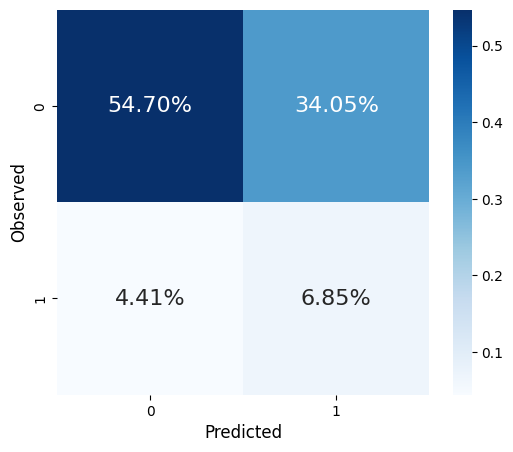

In [70]:
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1,\
                         **best_params) # **는 dictionary 를 푸는것 즉, 
                        #'max_depth': 6, 'scale_pos_weight': 7.789170026526649, 'reg_lambda': 0.000830400796215136, 'reg_alpha': 4.5691476717544044e-07
clf.fit(X_train, y_train)

_, y_prob, y_pred = evaluate_class_mdl(clf, X_train, X_test, y_train, y_test)

## 2) Error Analysis

### 2-1. Improvement

`Confusion Matrix`를 자세히 살펴보면 `False Positive`보다 `True Positive`가 60% 더 많지만 `False Positive`가 결과적으로 더 심각한 비용을 발생시킨다.
그러나 우리가 설정한 제약으로 인해 `True Positive`의 절반 이상이 결국 재입원으로 분류될 것다. (30일 이상 지난 환자도 재분류하는 제약)

In [56]:
X_orig_test['readmitted'].value_counts()

readmitted
NO     16461
>30    10644
<30     3425
Name: count, dtype: int64

대부분의 모델 목표가 30일 이상 재입원을 예상하므로 긍정적인 클래스가 이 그룹을 독점적으로 나타낸다. 
30일 이상 재입원 하지 않은 것에 대한 `False Positive` 오분류는 `NO` 에 대한 오분류만큼 나쁘지 않다. 
그렇다면 30일 이후 재입원에 대한 오탐지 비율은 얼마일까요?

In [57]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred})
preds_df[(preds_df.y_true==0) & (preds_df.y_pred==1)].value_counts(normalize=True)

readmitted  y_true  y_pred
NO          0       1         0.502237
>30         0       1         0.497763
Name: proportion, dtype: float64

실제로 오탐지의 거의 절반(전체 테스트 샘플의 34.72%)이 결국 재입원하였으므로 사전 예방 조치를 취하는 것이 나쁜 것이 아니라고 판단된다. 
우리가 고려해야 할 잘못된 결과는 나머지 절반에 대한 부분이다.

### 2-2. Error를 주제 그룹으로 나눠보자

#### 2-2-1. Error를 그룹별로 비교해보기 위해 함수를 하나 만들어보자

In [58]:
def set_header_font():
    return [dict(selector="th", props=[("font-size", "14pt")])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan
    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                 index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):

    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),\
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)
    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,\
                               plot=True, compare_fpr=False):
    
    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5)) # 1 행 2열
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()

#### 2-2-2. 그룹 별 에러 분석

**몇 가지 인구통계 정보를 통한 분석 (나이)**

In [59]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='age')

Error breakdown for group 'age'


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
age,,,,,,,,
'Over 60 years',"20,566",57.8%,16.3%,61.8%,25.8%,62.5%,38.2%,42.7%
'30-60 years',"9,201",67.8%,16.9%,58.3%,26.2%,67.6%,41.7%,31.2%
'30 years or younger',763,74.7%,25.6%,70.7%,37.5%,77.7%,29.3%,24.8%


**몇 가지 인구통계 정보를 통한 분석 (성별, 성별 미상 제외)**

In [60]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='gender',\
                         exclude_groups=['Unknown/Invalid'])

Error breakdown for group 'gender'


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
gender,,,,,,,,
Female,"16,448",60.0%,16.5%,61.7%,26.0%,64.5%,38.3%,40.2%
Male,"14,080",62.6%,16.8%,60.2%,26.2%,65.0%,39.8%,37.1%


`Confusion Matrix`를 양쪽에 나란히 두고 비교하면 분석할 때 편하다.

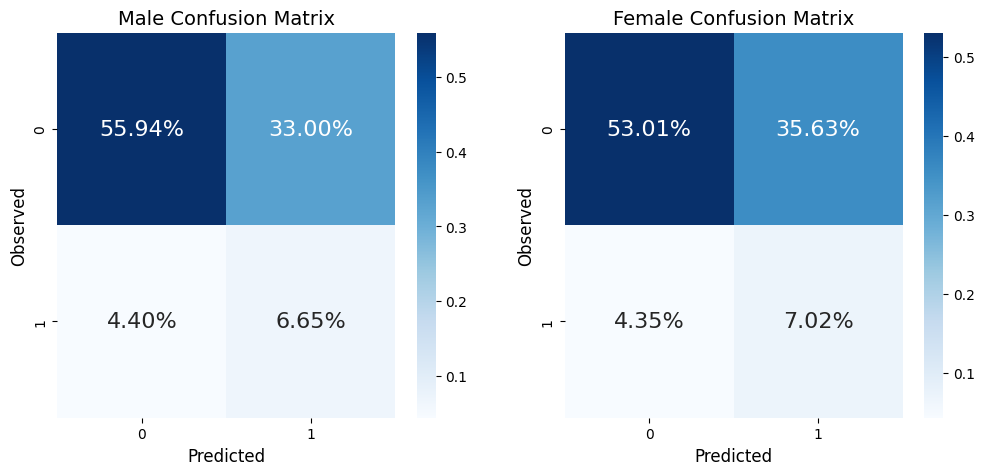

In [61]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male']==1], y_pred[X_test['gender_Male']==1],\
                           y_test[X_test['gender_Female']==1], y_pred[X_test['gender_Female']==1],\
                           'Male', 'Female')

**몇 가지 의학적 특징을 통한 분석**

아마도 몇몇 의학적 특징은 인구 통계학적 특징보다 더 뚜렷한 차이가 있을 수도 있다.

In [62]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='admission_source_id')

Error breakdown for group 'admission_source_id'


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
admission_source_id,,,,,,,,
Emergency,"17,228",58.2%,16.9%,64.8%,26.8%,64.7%,35.2%,42.7%
Referral,"9,303",65.3%,16.9%,56.5%,26.0%,65.0%,43.5%,33.7%
Other,"3,999",64.7%,14.3%,53.0%,22.5%,63.4%,47.0%,34.1%


In [63]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=X_orig_test, group_col='had_inpatient_days')

Error breakdown for group 'had_inpatient_days'


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
had_inpatient_days,,,,,,,,
False,"20,292",78.2%,14.3%,31.7%,19.7%,62.3%,68.3%,17.5%
True,"10,238",27.6%,17.6%,90.6%,29.4%,57.0%,9.4%,85.1%


꽤 명확하게 보인다.. 
무슨 일이 일어나고 있는지 이해하기 위해 이것을 비교해보자.

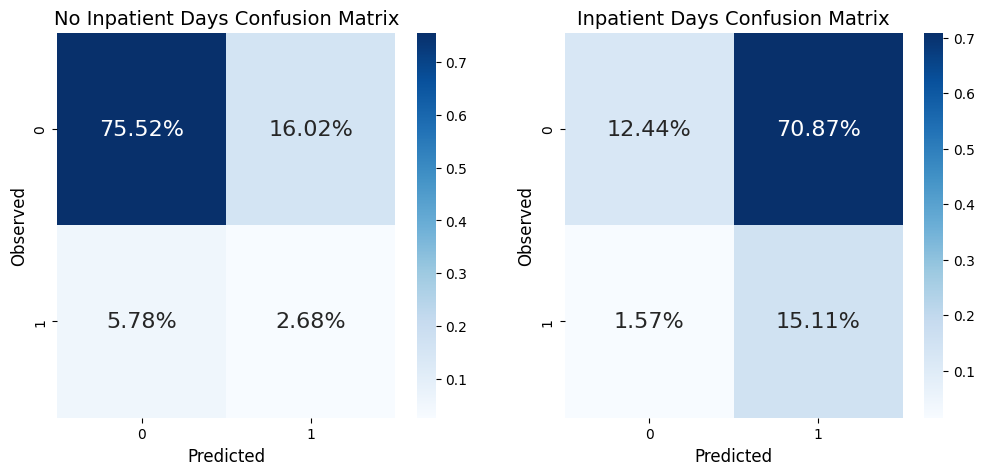

In [64]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days']==0], y_pred[X_test['had_inpatient_days']==0],\
                           y_test[X_test['had_inpatient_days']==1], y_pred[X_test['had_inpatient_days']==1],\
                           'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

30일 이후 재입원을 포함하지 않는 하위 집합이 유사한 `Confusion Matrix`를 갖는지 보자.

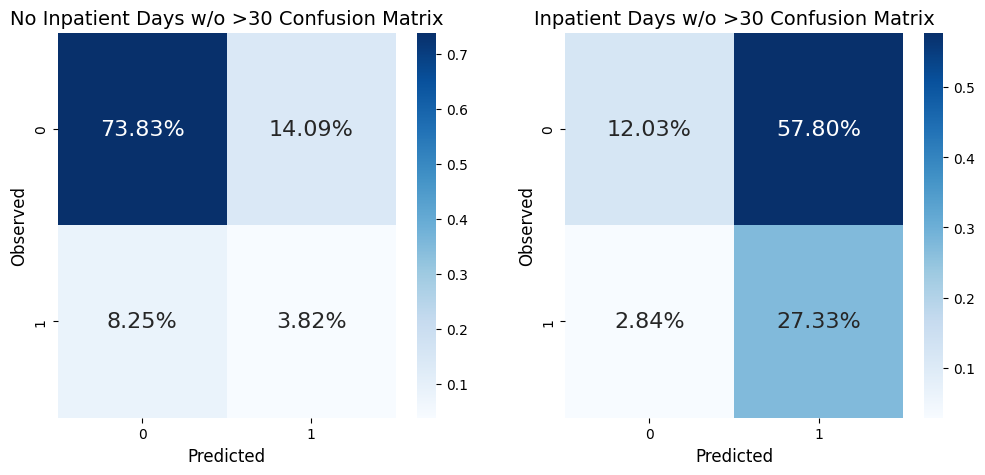

In [65]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==0) & (X_orig_test['readmitted']!='>30')],\
                           y_test[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')], y_pred[(X_test['had_inpatient_days']==1) & (X_orig_test['readmitted']!='>30')],\
                           'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

# 🥇Session 3 - 「주제그룹 분석」

## 3) Feature Importance and More Advanced Error Analysis

### 3-1. Sample data

In [66]:
X_test_sample = X_test[(X_orig_test['readmitted']!='>30')].sample(frac=0.1) # 너무 많으니까 샘플10프로만
y_test_sample = y_test.loc[X_test_sample.index]

y_prob_sample = clf.predict_proba(X_test_sample)[:,1]
y_pred_sample = np.where(y_prob_sample > 0.5, 1, 0)

In [67]:
X_test_sample

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Female,gender_Male,gender_Unknown/Invalid,age_'30 years or younger',age_'30-60 years',age_'Over 60 years',discharge_disposition_id_'Discharged to Home',discharge_disposition_id_Other,admission_source_id_Emergency,...,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Missing,medical_specialty_Other,primary_diagnosis_'Genitourinary Issues',primary_diagnosis_'Musculoskeletal Issues',primary_diagnosis_'Respiratory Issues',primary_diagnosis_Diabetes,primary_diagnosis_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
20489,5,42,1,10,9,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
953,3,60,0,10,7,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
3714,13,75,6,28,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1
18373,5,41,2,20,9,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0
50628,2,35,0,15,4,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52935,8,55,1,14,7,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
61979,3,47,0,9,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1
81860,3,45,0,14,9,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1
66276,3,62,0,17,7,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1


### 3-2. SHAP values 생성하기

In [68]:
%%time
shap_explainer = shap.Explainer(clf, X_train)
shap_values = shap_explainer(X_test_sample)

CPU times: user 3.09 s, sys: 28.2 ms, total: 3.12 s
Wall time: 3.14 s


In [69]:
shap_values.values

array([[ 0.03215759,  0.01184788,  0.00497593, ...,  0.        ,
         0.02693872,  0.        ],
       [-0.01671789,  0.00612837,  0.03028034, ...,  0.        ,
         0.02440977,  0.        ],
       [ 0.18329713, -0.20168158, -0.00624098, ...,  0.        ,
         0.03798702,  0.        ],
       ...,
       [-0.02209763,  0.09141709,  0.02512885, ...,  0.        ,
         0.06036447,  0.        ],
       [-0.03119444,  0.20116684,  0.04736794, ...,  0.        ,
         0.05824227,  0.        ],
       [ 0.0332773 ,  0.06513419,  0.00565428, ...,  0.        ,
         0.03300435,  0.        ]])

In [70]:
print(shap_values.values.shape)

(1989, 54)


### 3-3. Feature Importance Plots

한 축에서 SHAP 값의 절대값을 평균화하면 기능 중요도 측정값(Feature당 하나)

In [71]:
np.abs(shap_values.values).mean(axis=0)

array([8.37849352e-02, 7.61798555e-02, 4.04295835e-02, 7.59159405e-02,
       5.41435218e-02, 1.85507388e-02, 1.76516615e-03, 4.68861542e-02,
       2.95377683e-01, 6.47183091e-03, 1.24453943e-02, 1.87855544e-03,
       1.06106241e-02, 3.27106424e-03, 8.95382162e-03, 1.49467936e-02,
       4.96372837e-03, 1.19106950e-02, 0.00000000e+00, 4.28483750e-03,
       5.09101054e-03, 3.42697291e-02, 1.62779593e-01, 2.04146564e-04,
       5.71523433e-03, 2.19687590e-02, 5.30796971e-03, 1.78000962e-02,
       1.53103415e-02, 6.28907045e-03, 5.46808824e-03, 6.01827396e-03,
       7.05724264e-03, 1.61507781e-03, 1.47469634e-02, 4.05036093e-02,
       1.43334549e-02, 3.44481907e-02, 1.93616079e-03, 3.83789141e-04,
       2.46791786e-03, 1.34262058e-03, 7.89729392e-03, 6.65273339e-03,
       2.38539133e-02, 1.85155404e-03, 2.40239756e-02, 1.44678779e-02,
       4.62959112e-03, 7.25888144e-03, 1.35627489e-02, 8.58713472e-05,
       6.41059829e-02, 5.57499403e-04])

이 함수는 각 Feature의 Importance 순위 표시

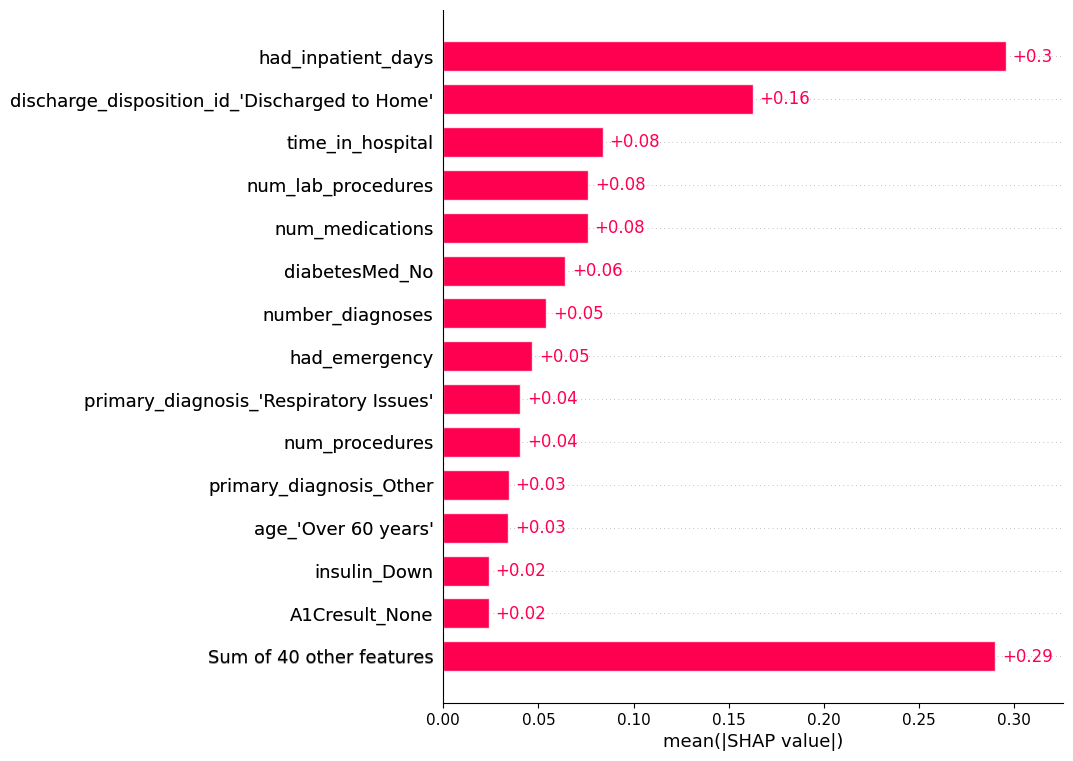

In [72]:
shap.plots.bar(shap_values, max_display=15)

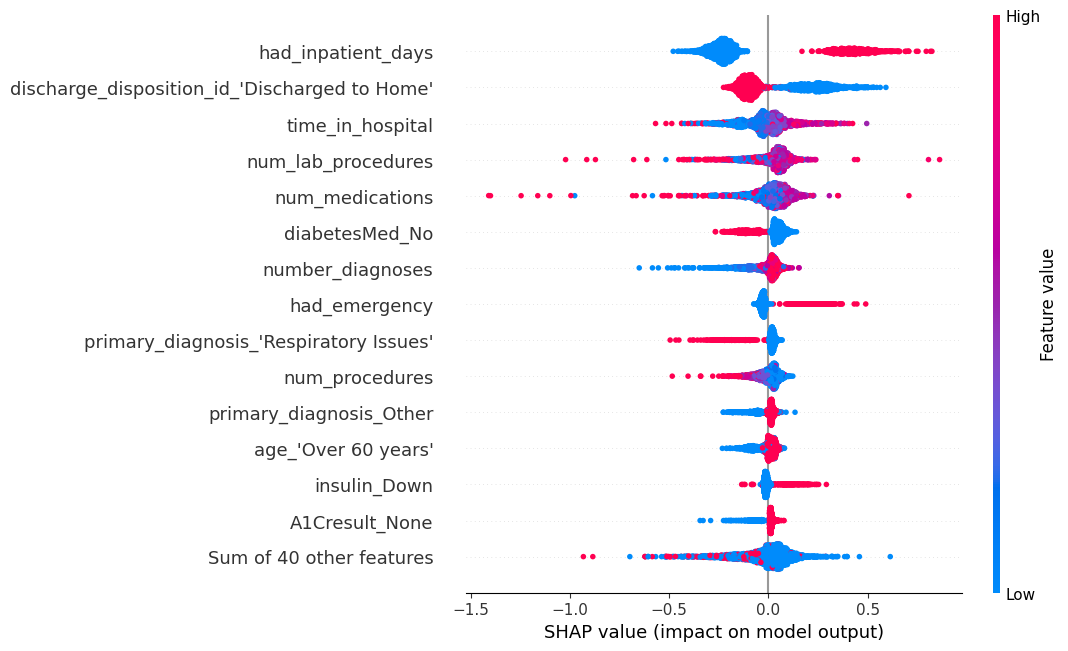

In [73]:
shap.plots.beeswarm(shap_values, max_display=15)

### 3-4. Scatter Plots

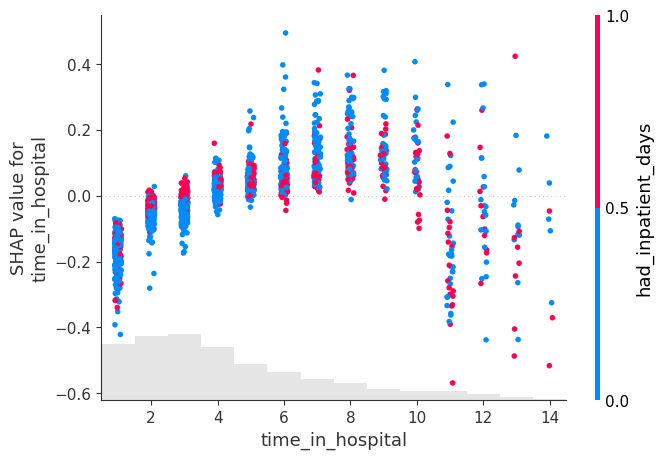

In [74]:
shap.plots.scatter(shap_values[:,"time_in_hospital"],\
                   color=shap_values[:,"had_inpatient_days"]) # 제일 중요한 애를 컬러로 

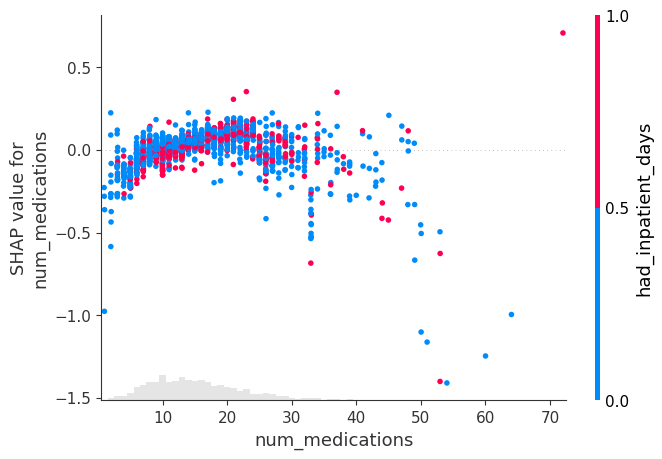

In [75]:
shap.plots.scatter(shap_values[:,"num_medications"],\
                   color=shap_values[:,"had_inpatient_days"])

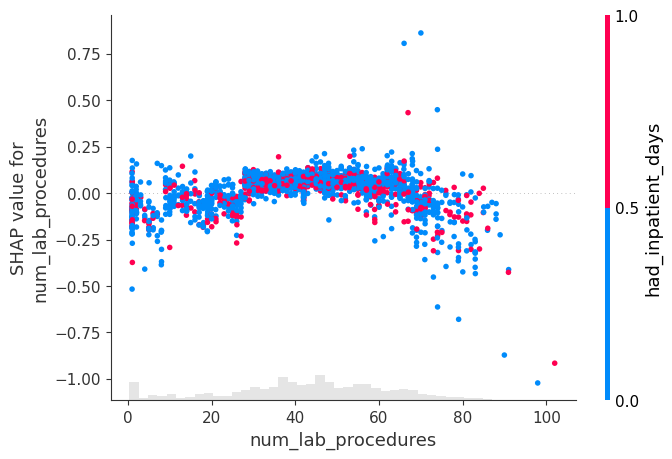

In [76]:
shap.plots.scatter(shap_values[:,"num_lab_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

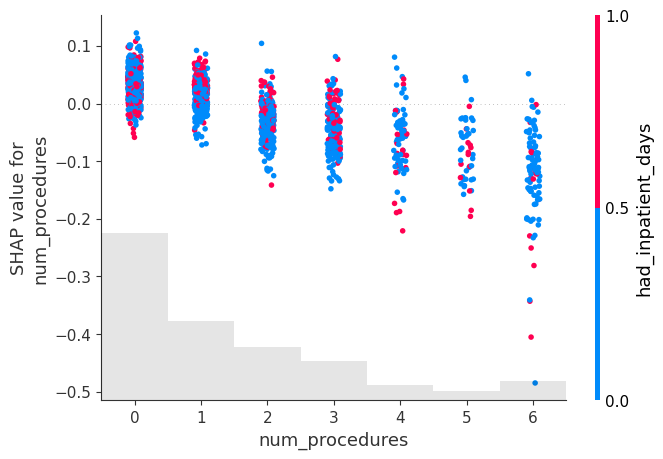

In [77]:
shap.plots.scatter(shap_values[:,"num_procedures"],\
                   color=shap_values[:,"had_inpatient_days"])

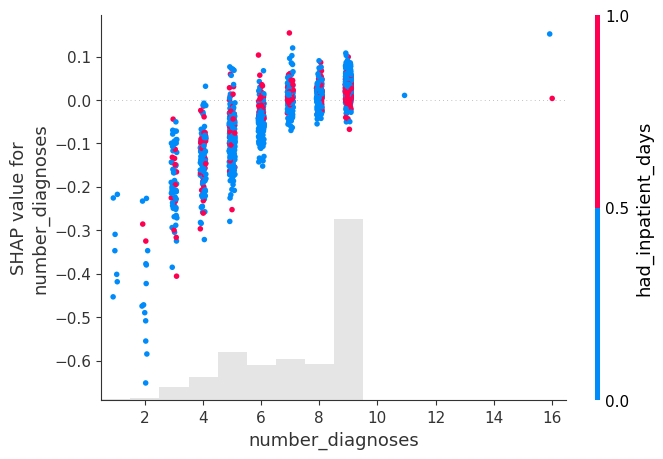

In [78]:
shap.plots.scatter(shap_values[:,"number_diagnoses"], color=shap_values[:,"had_inpatient_days"])

### 3-5. 에러를 줄이는 몇 가지 전략

#### 3-5-1. Post-processing (predictions)

이것은 일종의 편법이라고 생각할 수도 있지만 Positive 클래스를 예측하는 경우에 대한 임계값 조절하는 것은 일반적인 일이다. 임계값이 일관되게 0.5일 필요는 없다. 에러를 최소화하기 위해 확률 자체를 보정하는 경우도 있다.

In [79]:
preds_df = pd.DataFrame({'readmitted':X_orig_test['readmitted'],\
                         'had_inpatient_days':X_test['had_inpatient_days'],\
                         'y_true':y_test.astype(int),\
                         'y_pred':y_pred,
                         'y_prob':y_prob})
preds_df = preds_df[(preds_df['readmitted']!='>30')]

preds_df['y_pred_new'] = np.where(preds_df.had_inpatient_days==0,\
                                  np.where(preds_df.y_prob > 0.45, 1, 0),
                                  np.where(preds_df.y_prob > 0.59, 1, 0))

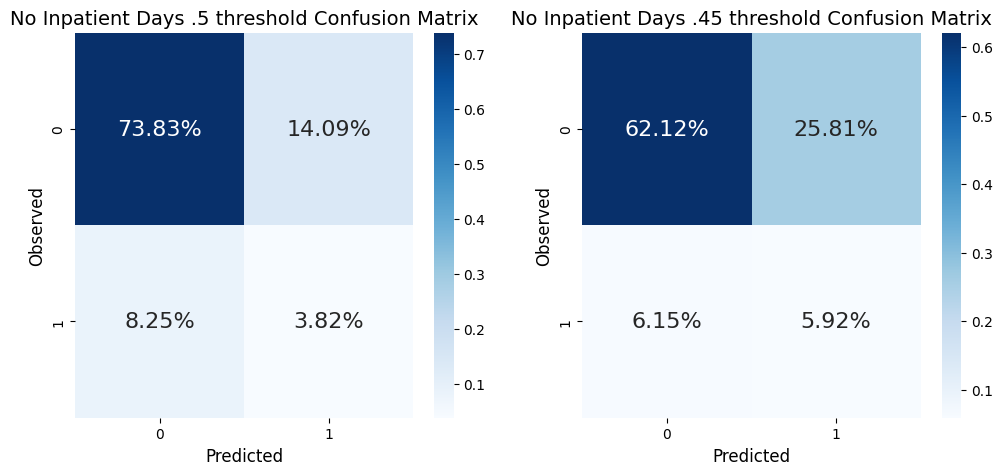

In [80]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==0, 'y_pred_new'],
                               'No Inpatient Days .5 threshold', 'No Inpatient Days .45 threshold')

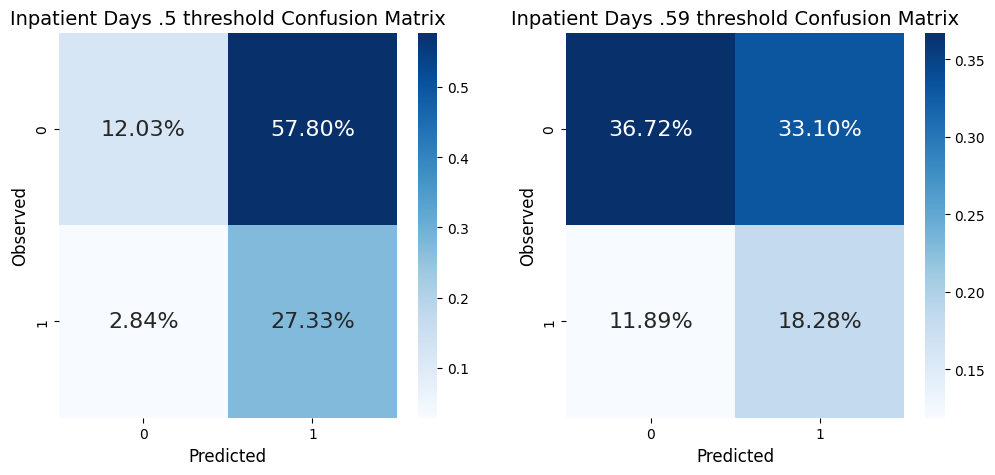

In [81]:
_ = compare_confusion_matrices(preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred'],\
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_true'],
                               preds_df.loc[preds_df.had_inpatient_days==1, 'y_pred_new'],
                               'Inpatient Days .5 threshold', 'Inpatient Days .59 threshold')

#### 3-5-2. In-processing (model)

- `sample_weight` 혹은 다양한 `sampling` 기법을 사용하여 모델이 가장 못 맞추는 샘플에 더 집중하도록 한다.
- 코호트에 따라 `False Negative`를 다르게 패널티화하는 맞춤형 `loss function` 활용
- 대신 다중 클래스 분류 모델을 사용해보자. 아마도 `NO`와 `>30`을 분리하면 모델의 성능이 향상될 수 있다.

#### 3-5-3. Pre-processing (data)

- 도메인 전문가와 함께 에러를 검토하고 더 잘 분류하는 데 도움이 될 수 있는 새로운 Feature를 찾아보는게 좋다.
- 이전에 엔지니어링된 일부 Feature가 특징을 잘 분류할 수 있는 특성이 엔지니어링 과정에서 사라졌을 수도 있다. 예를 들어 연령은 연령 그룹에 있지만 더 작은 그룹 또는 실제 연령으로 사용한다면 오류가 더 줄어들 것입니다. (대신 연산량이 많아짐)